<a href="https://colab.research.google.com/github/Xiaoyan-Fu/amptorch/blob/active_learning/zeolite-ad-adamW-cos/AdamW_cos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/Xiaoyan-Fu/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics
!pip install -q --upgrade dftbook

  ERROR: Failed building wheel for simple-nn


In [ ]:
from sklearn.metrics import mean_squared_error
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import ase.io
from amp import Amp
from amp.model.neuralnetwork import NeuralNetwork
from amp.model import LossFunction
import operator
import amptorch
import copy
import matplotlib
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from skorch.callbacks import Checkpoint, EpochScoring
from skorch.callbacks.lr_scheduler import LRScheduler
import skorch.callbacks.base
from amptorch.gaussian import SNN_Gaussian
from amptorch.model import BPNN, CustomMSELoss
from amptorch.skorch_model import AMP
from amptorch.skorch_model.utils import target_extractor
from amptorch.analysis import parity_plot
from torch.utils.data import DataLoader
from torch.nn import init
from skorch.utils import to_numpy
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
from sklearn.model_selection import ShuffleSplit
from torch.optim.lr_scheduler import CosineAnnealingLR
from amptorch.modifications import AtomsDataset_per_image, CustomMSELoss_per_image, energy_score, AMPCalculator
from amptorch.data_preprocess import collate_amp
!wget https://github.com/Xiaoyan-Fu/amptorch/raw/active_learning/zeolite-ad-adamW-cos/traj_taged_adsorptionenergy.traj

/usr/local/lib/python3.6/dist-packages/simple_nn/utils/graph.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/io

--2020-06-24 00:43:37--  https://github.com/Xiaoyan-Fu/amptorch/raw/active_learning/zeolite-ad-adamW-cos/traj_taged_adsorptionenergy.traj
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Xiaoyan-Fu/amptorch/active_learning/zeolite-ad-adamW-cos/traj_taged_adsorptionenergy.traj [following]
--2020-06-24 00:43:38--  https://raw.githubusercontent.com/Xiaoyan-Fu/amptorch/active_learning/zeolite-ad-adamW-cos/traj_taged_adsorptionenergy.traj
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9075371 (8.7M) [application/octet-stream]
Saving to: ‘traj_taged_adsorptionenergy.traj.1’

traj_taged_adsorpti 100%[======

In [ ]:
images = ase.io.read('./traj_taged_adsorptionenergy.traj', index=':')
def Split(images):
  '''random split'''
  args = (np.arange(len(images)),)
  cv = ShuffleSplit(n_splits=10, random_state=None, test_size=0.2, train_size=None)
  idx_train, idx_test = next(iter(cv.split(*args, groups=None)))
  train_images = [images[index] for index in idx_train]
  test_images = [images[index] for index in idx_test]
  return train_images, test_images
train_images_original, test_images_original = Split(images)
train_images = copy.deepcopy(train_images_original)
test_images = copy.deepcopy(test_images_original)

In [ ]:
assignments = {
    'epochs': 3000,
    'learning_rate': 0.02,
    'hidden_layers': 4,
    'num_nodes': 70,
    'optimizer' : optim.AdamW,
    'batchsize' : 40,
    'T_max' : 3000,
    'weight_decay': 0.1,
    'LRScheduler': CosineAnnealingLR
}
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 6.5
# Gs define
DFT_energies_test = [image.get_potential_energy() for image in test_images]
torch.set_num_threads(1)
# loads best validation loss at the end of training
class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('valid_best_params.pt')
cp = Checkpoint(monitor='valid_loss_best', fn_prefix='valid_best_')
load_best_valid_loss = train_end_load_best_valid_loss()
# hyperparameters and Gs defination

In [ ]:
training_data = AtomsDataset_per_image(train_images, SNN_Gaussian, Gs, forcetraining=False,
        label="zeolite", cores=1, delta_data=None, specific_atoms=True)
# database defination

Calculating fingerprints...
Fingerprints Calculated!


In [ ]:
net = NeuralNetRegressor(
    module=BPNN(
        training_data.elements,
        [training_data.fp_length, assignments["hidden_layers"], assignments["num_nodes"]],
        "cpu",
        forcetraining=False,
    ),
    criterion=CustomMSELoss_per_image,
    criterion__force_coefficient=0,
    optimizer=assignments["optimizer"],
    lr=assignments["learning_rate"],
    batch_size=assignments["batchsize"],
    max_epochs=assignments["epochs"],
    iterator_train__collate_fn=collate_amp,
    iterator_train__shuffle=False,
    iterator_valid__collate_fn=collate_amp,
    iterator_valid__shuffle=False,
    optimizer__weight_decay=assignments["weight_decay"],
    device="cpu",
    train_split=CVSplit(5),
    callbacks=[
        EpochScoring(
            energy_score,
            on_train=True,
            use_caching=True,
            target_extractor=target_extractor,
        ),
        ('lr_scheduler',
          LRScheduler(policy=assignments['LRScheduler'], T_max=assignments["T_max"],)
        ),
        cp,
        load_best_valid_loss,
        # LR_schedule
    ],
)

In [ ]:
# train
calc = AMP(training_data, net, 'zeolite', specific_atoms=True)
calc.train(overwrite=True)
energy_rmse_train = net.history[:, ('train_loss')]
energy_rmse_valid = net.history[:, ('valid_loss')]
for image in test_images:
  image.set_calculator(calc)
pred_energies_test = [image.get_potential_energy() for image in test_images]
energy_rmse_test = np.sqrt(mean_squared_error(pred_energies_test, DFT_energies_test))

  epoch    energy_score    train_loss    valid_loss    cp     dur
-------  --------------  ------------  ------------  ----  ------
      1         29.1467       21.1302        2.9103     +  0.7843


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          4.8342        4.5278        3.1340        0.4458
      3          3.1724        3.1438        2.7904     +  0.4341
      4          2.8913        2.8768        2.5428     +  0.4592
      5          2.9281        2.9010        2.4681     +  0.4367
      6          2.7222        2.6875        2.4027     +  0.4323
      7          2.7201        2.6785        2.5468        0.4324
      8          2.9586        2.8759        2.8765        0.4290
      9          2.6436        2.6173        4.2831        0.4295
     10          2.9686        2.8415        2.5776        0.4298
     11          3.5318        3.4102        2.4597        0.4325
     12          2.6965        2.6328        2.6668        0.4500
     13          2.5866        2.5456        3.3504        0.4397
     14          3.6492        3.5036        2.6913        0.4326
     15          3.3877        3.2507        2.5422        0.4391
     16          2.4794        2.4665        2.9413        0.4338
     17   

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


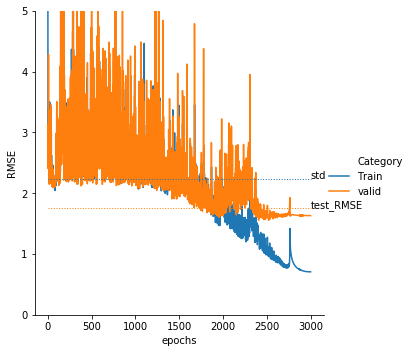

In [ ]:
# plot
import seaborn as sns
%matplotlib inline
experiment = 'adamW_minibatch_cos'
epoch = assignments['epochs']
epochs = [i for i in range(1,epoch+1)]
df = pd.DataFrame(
    {
        'RMSE': energy_rmse_train + energy_rmse_valid,
        'Experiment':[experiment] * (epoch * 2),
        'Category': ['Train'] * epoch + ['valid']  * epoch,
        'epochs': epochs * 2,
    })
g = sns.relplot(x="epochs", y="RMSE", hue="Category", kind="line", data=df)
stdv = np.std([image.get_potential_energy() for image in images])
g.ax.text(max(df['epochs']), stdv, 'std')
g.ax.plot([0, max(df['epochs'])], [stdv, stdv], ls=':',linewidth=1)
g.ax.set_ylim(0,5)
label = 'test_RMSE'
value = energy_rmse_test
g.ax.text(max(df['epochs']), value, label)
g.ax.plot([0, max(df['epochs'])], [value, value], ls=':',linewidth=1)